<a href="https://colab.research.google.com/github/MarinaComotti/Malaria_Project_Deep_Learning_CV/blob/main/Malaria_detection_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Malaria detection - Binary clasification with CNN and Transfer learning** 🔬 💻

### **Introduction and Objetives**
In this project, we work with the 'Malaria' dataset from TensorFlow Datasets to create a binary classification model applying Transfer Learning and Fine-tuning techniques with TensorFlow and Keras. With this approach, we aim for the model to learn fundamental patterns and features for malaria detection in blood smear images.

The objective of this project is to explore different deep learning techniques and create a comprehensive experience from data analysis and preprocessing to model creation, evaluation and deploying. As a final step, the model will be brought to production by building an application with the Streamlit tool so that it can be used and tested by different users. Through this end-to-end approach, we aspire to gain a profound understanding of the complexities and challenges associated with the practical application of deep learning techniques in a complete project.

### **Data**
The Malaria dataset consists of images of cell samples that are labeled as either infected or uninfected. It contains a total of 27,558 images, with roughly equal distribution between the two classes. This dataset is available in TensorFlow Datasets, and it was published in 2018.

### **About Malaria**
Malaria (also known as paludism) is a potentially deadly disease caused by a parasite transmitted through the bite of mosquitoes belonging to the Anopheles genus. It is typically prevalent in tropical countries. Symptoms can range from mild, such as fever, chills, and headache, to severe, including fatigue, confusion, seizures, and difficulty breathing. For diagnosis, blood samples are examined under a microscope, where the parasite is detected within red blood cells. Rapid diagnostic tests (RDTs) also exist and are used for diagnosis in remote areas where a microscope may not be accessible.

## **Import Libraries**

In [ ]:
# modeling & evaluation
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
from keras import layers
from keras.applications import VGG16
from sklearn.metrics import classification_report
# data visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
# Data preprocessing
import numpy as np
from PIL import Image
import os
# data exploration and statistics
import pandas as pd

In [ ]:
print(tf.__version__)

2.15.0



## **Data Acquisition**

The data will be downloaded from the TensorFlow dataset.

In [ ]:
raw_dataset, info = tfds.load("malaria", with_info=True, as_supervised=True, shuffle_files=True)

## **Exploratory Data Analysis**
In this stage, data analysis will be carried out to obtain important information that can be used in subsequent stages, such as data preprocessing and model training.


In [ ]:
# Get information about dataset
builder = tfds.builder('malaria')
info = builder.info
print('Information about dataset: \n')
print(info)

Information about dataset: 

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite det

In [ ]:
print('Dataset structure: \n')
raw_dataset

Dataset structure: 



{'train': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [ ]:
# About dataset
print('Split: ', list(info.splits.keys()))
TOTAL_IMAGES = info.splits['train'].num_examples
print('Total number of images: ', TOTAL_IMAGES)
print('Data shards: ', info.splits['train'].num_shards)

Split:  ['train']
Total number of images:  27558
Data shards:  4


In [ ]:
# About labels
label_info = info.features['label']
NUM_CLASSES =  label_info.num_classes
print("Number of classes: ", NUM_CLASSES)
LABEL_NAMES = label_info.names
print(f'Class names: "{LABEL_NAMES[0]}" - "{LABEL_NAMES[1]}"')

Number of classes:  2
Class names: "parasitized" - "uninfected"


The dataset contains **27000 images** divided into 2 classes: **parasitized** and **uninfected**

In [ ]:
dataset = raw_dataset['train']

In [ ]:
# Original format of the images

def show_images_type(data, number_samples=5):
  for example in data.take(number_samples):
      image = example[0].numpy()
      temp_path = "/tmp/temp_image.jpg"
      Image.fromarray(image).save(temp_path)

      with Image.open(temp_path) as img:
          image_format = img.format

      print(f"Tipe of file: {image_format}")
  os.remove(temp_path)

print('Image format: \n ')
show_images_type(dataset, 8)

Image format: 
 
Tipe of file: JPEG
Tipe of file: JPEG
Tipe of file: JPEG
Tipe of file: JPEG
Tipe of file: JPEG
Tipe of file: JPEG
Tipe of file: JPEG
Tipe of file: JPEG


Number of images per class:


In [ ]:
def images_per_class(dataset, name='dataset', num_classes=2):
  class_counts = [0] * num_classes

  for example in dataset:
      label = example[1].numpy()
      class_counts[label] += 1

  print(f"Number of images by class in the {name}:")
  for i in range(num_classes):
      print(f"Clase {i} '{LABEL_NAMES[i]}': {class_counts[i]} images")


In [ ]:
images_per_class(dataset, 'dataset')

Number of images by class in the dataset:
Clase 0 'parasitized': 13779 images
Clase 1 'uninfected': 13779 images


There are **13779 images in each class**

Displaying some images with their respective classes:

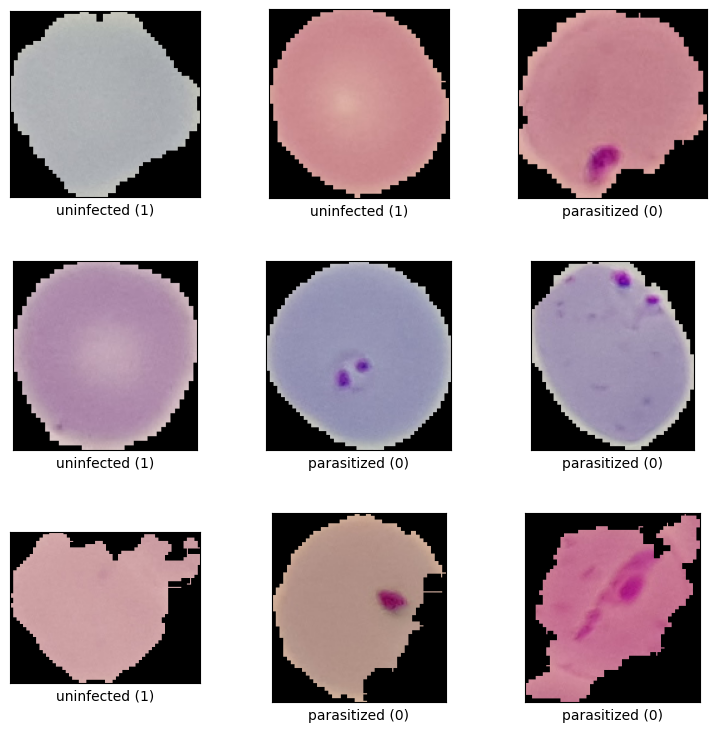

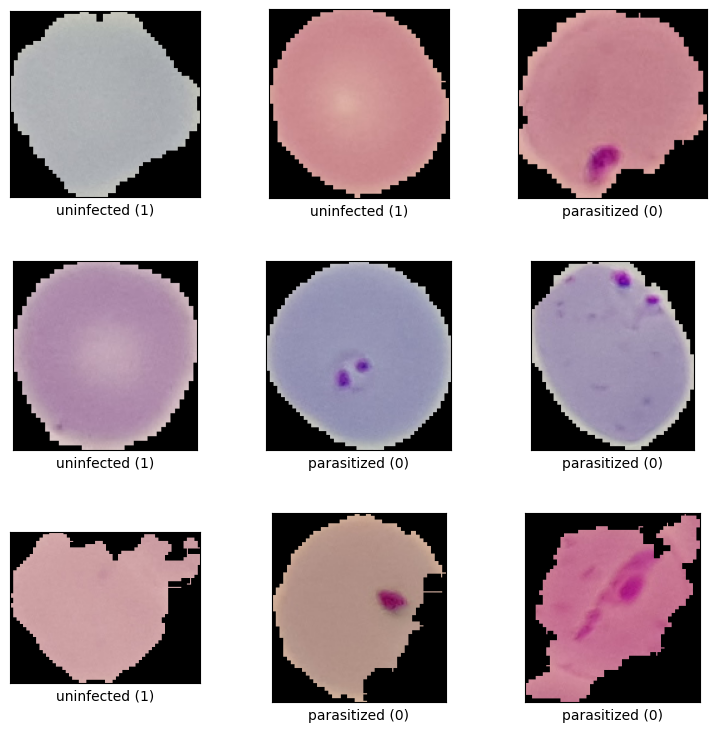

In [ ]:
tfds.show_examples(dataset,info)

Upon viewing a random group of images, we can see that they all have a black background and the cells are positioned in the center. Also, it is observed that the colors are quite uniform with shades between pink and violet. This information will be useful when choosing the layers to apply in the Data Augmentation technique that will be performed during data preprocessing.

**Calculating statistics on image dimensions:** before passing the images to the model, a common width and height need to be established. To find the correct values, we analyze statistical measures such as mean, standard deviation, and the maximum, minimum, and range of width and height.


In [ ]:
df = tfds.as_dataframe(dataset, info)
image_sizes= df['image'].apply(lambda x: x.shape[:2])

In [ ]:
# Observation of image sizes:
def show_sizes_images(dimensions, num_examples=4):
    for index, value in dimensions.head(num_examples).items():
        print(f"Image size {index + 1}: {value}")

show_sizes_images(image_sizes, num_examples=10)

Image size 1: (151, 115)
Image size 2: (121, 115)
Image size 3: (157, 136)
Image size 4: (151, 148)
Image size 5: (133, 112)
Image size 6: (109, 118)
Image size 7: (115, 115)
Image size 8: (103, 91)
Image size 9: (118, 142)
Image size 10: (145, 142)


In [ ]:
def show_dimension_statistics(dimensions):
  mean = np.mean(list(dimensions), axis=0)

  image_dimensions = dimensions.apply(lambda x: pd.Series(x[:2], index=['height', 'width']))
  max_dimensions = image_dimensions.max()
  min_dimensions = image_dimensions.min()

  total_range_width = max_dimensions['width'] - min_dimensions['width']
  total_range_height = max_dimensions['height'] - min_dimensions['height']

  std = image_dimensions.std()

  print("Mean height:", int(mean[0]), " - Mean width:", int(mean[1]))
  print(f"Standard deviation of height: {std['height']:.2f}", f" - Standard deviation of width: {std['width']:.2f}")
  print(f"Max height: {max_dimensions[0]}")
  print(f"Min height: {min_dimensions[0]}")
  print(f"Total Range of height: {total_range_height}")
  print(f"Max width: {max_dimensions[1]}")
  print(f"Min width: {min_dimensions[1]}")
  print(f"Total Range of width: {total_range_width}")



show_dimension_statistics(image_sizes)

Mean height: 132  - Mean width: 132
Standard deviation of height: 20.62  - Standard deviation of width: 20.02
Max height: 385
Min height: 40
Total Range of height: 345
Max width: 394
Min width: 46
Total Range of width: 348


The statistical values ​​on the size of the images found were:

* **height:**
      mean: 132
      std: 20.62
      max: 385
      min: 40
      total range: 345
* **width:**
      mean: 132
      std: 20.02
      max: 394
      min: 46
      total range: 348







## **Data Preprocessing**

Now, transformations will be applied to the data in order to prepare it properly for model training:

When analyzing the statistical values on the size of the images, we found that there is a lot of variability and dispersion, with some very extreme values. Later, the size of the images will have to be adjusted to a value common to all of them. The common value chosen will be the mean (132, 132), so during this step, images with extreme sizes will undergo a large shift, and this could introduce unwanted noise into the model.

To reduce the impact of this possible problem, only those images whose height and width do not exceed the mean value, 132, by more than 40 pixels (approx. 2 x std) will be used. In other words, **images with a height and width greater than 172 or less than 92 will be discarded**.

In [ ]:
# Filter images
def filter_images(img):
    image_shape = tf.shape(img)
    height_condition = tf.logical_and(image_shape[0] >= 92, image_shape[0] <= 172)
    width_condition = tf.logical_and(image_shape[1] >= 92, image_shape[1] <= 172)
    return tf.logical_and(height_condition, width_condition)

filtered_dataset = dataset.filter(lambda img, label: filter_images(img))
print(f"Number of images whose size is within the range [92, 172]: ", len(list(filtered_dataset)))

Number of images whose size is within the range [92, 172]:  25328


Of the total 27558, **2230  images have been discarded** due to their extreme height and width sizes, which could negatively impact model training. From now on, we will work only with the remaining 25,328 images.

In [ ]:
images_per_class(filtered_dataset, 'dataset')

Number of images by class in the dataset:
Clase 0 'parasitized': 12484 images
Clase 1 'uninfected': 12844 images


We can see that there is now a different number of images in each of the classes because some elements have been removed. In training, using a dataset that is not balanced could introduce bias in the model toward the classes with more images. It could also make certain evaluation metrics, such as accuracy, unclear. To avoid this problem, 360 images will be removed from class 1, 'uninfected,' so that both categories have 12,484 elements each:

In [ ]:
def remove_images(dataset):
  class_0= dataset.filter(lambda img, label: label == 0)
  class_1 = dataset.filter(lambda img, label: label == 1)
  class_1 = class_1.skip(360)
  return class_0.concatenate(class_1)


balanced_dataset = remove_images(filtered_dataset)

In [ ]:
images_per_class(balanced_dataset, 'dataset')

Number of images by class in the dataset:
Clase 0 'parasitized': 12484 images
Clase 1 'uninfected': 12484 images


The dataset is now balanced, with **12484 images in each class (24968 images in total)**

**Creation of dataset splits:**

The dataset will be subdivided as follows:

 - Training set: 70%
 - Validation set: 15%
 - Test set 15%


In [ ]:
def generate_splits(dataset, num_per_class):
  # separating images by class
  class_0 = dataset.filter(lambda img, label: label == 0)
  class_1 = dataset.filter(lambda img, label: label == 1)

  # computing the number of images each subset should have
  train_num = int(0.70 * num_per_class)
  test_val_num = int(0.15 * num_per_class)

  # splitting images of class 0
  train_class_0 = class_0.take(train_num)
  remaining_images = class_0.skip(train_num)
  test_class_0 = remaining_images.take(test_val_num)
  val_class_0 = remaining_images.skip(test_val_num)

  # splitting images of class 1
  train_class_1 = class_1.take(train_num)
  remaining_images = class_1.skip(train_num)
  test_class_1 = remaining_images.take(test_val_num)
  val_class_1 = remaining_images.skip(test_val_num)

  # merging the final data
  train_data = train_class_0.concatenate(train_class_1)
  test_data = test_class_0.concatenate(test_class_1)
  val_data = val_class_0.concatenate(val_class_1)

  return train_data, test_data, val_data

In [ ]:
train_data, test_data, val_data = generate_splits(balanced_dataset, num_per_class=12484)

In [ ]:
# Number of images in the training, validation, and test sets
train_size = len(list(train_data))
val_size = len(list(val_data))
test_size = len(list(test_data))
print('Number of images in the Training Set:', train_size)
print('Number of images in the Validation Set:', val_size)
print('Number of images in the Test Set:', test_size)

Number of images in the Training Set: 17476
Number of images in the Validation Set: 3748
Number of images in the Test Set: 3744


In [ ]:
def visualize_images_pie(train_data, val_data, test_data):
    fig = px.pie(names=['Training Set', 'Validation Set', 'Test Set'], values=[train_size, val_size, test_size], title='Number of Images in each Set')
    fig.show()

visualize_images_pie(train_data, val_data, test_data)

In [ ]:
images_per_class(train_data, 'Train set')
print("\n", '-'*30, "\n")
images_per_class(test_data, 'Test set')
print("\n", '-'*30, "\n")
images_per_class(val_data, 'Validation set')

Number of images by class in the Train set:
Clase 0 'parasitized': 8738 images
Clase 1 'uninfected': 8738 images

 ------------------------------ 

Number of images by class in the Test set:
Clase 0 'parasitized': 1872 images
Clase 1 'uninfected': 1872 images

 ------------------------------ 

Number of images by class in the Validation set:
Clase 0 'parasitized': 1874 images
Clase 1 'uninfected': 1874 images


**Data normalization**: To ensure that input values for the neural network are in the range of 0 to 1, the **Keras Rescaling layer** will be applied, dividing each pixel in every image by 255. Additionally, the **Keras Resizing layer** will be used to resize all images to (132, 132), as mentioned above:



In [ ]:
IMG_HEIGHT = 132
IMG_WIDTH = 132

resize_and_rescale = keras.Sequential([
  layers.Rescaling(1./255),
  layers.Resizing(height=IMG_HEIGHT, width=IMG_WIDTH)
])

def preprocess_image(image, label):
    image = resize_and_rescale(image)
    return image, label

train_data = train_data.map(preprocess_image)
val_data = val_data.map(preprocess_image)


**Optimization tools for data**, such as **caching, shuffling, batching, and prefetching**, will be applied to the training set and validation set. These techniques help improve the model training performance by optimizing data input for a more efficient and faster process:

In [ ]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE
def configure_for_performance(ds, buffer_size_shuffle):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=buffer_size_shuffle)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    ds = ds.batch(batch_size)
    return ds

optimized_train_data = configure_for_performance(train_data, train_size)
optimized_val_data = configure_for_performance(val_data, val_size)

**Visualization of the transformations that will be applied to the images during the Data Augmentation process in model training:**

To increase the diversity of the images in the training set, some Keras Image Preprocessing layers will be appended to the top of the model to apply the Data Augmentation technique during the training step.

However, before doing this, as a test, we will select one random image, apply each of these transformations to it separately, and visualize the resulting effects:
  

In [ ]:
def select_random_image(dataset):
  random_element = dataset.shuffle(buffer_size=17000).take(1)
  for image, label in random_element:
    return tf.cast(tf.expand_dims(image, 0), tf.float32)

selected_image = select_random_image(train_data)

In [ ]:
def show_layer_effect(image, layer):
  fig, axes = plt.subplots(1, 5, figsize=(12, 12))
  axes[0].imshow(image[0])
  axes[0].axis("off")
  axes[0].set_title("Original Image", fontsize=11)
  for i in range(1, 5):
    augmented_image = layer(image)
    axes[i].imshow(augmented_image[0])
    axes[i].axis("off")
    axes[i].set_title(f"RandomFlip {i}", fontsize=11)

1. **RandomFlip layer:** flips the images horizontally and vertically.
          mode="horizontal_and_vertical"

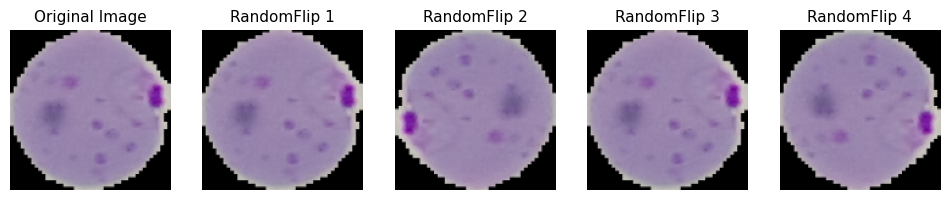

In [ ]:
layer = tf.keras.Sequential([
  layers.RandomFlip(mode="horizontal_and_vertical")
])
show_layer_effect(selected_image, layer)

2. **RandomRotation layer:** applies random rotations, filling empty space according to the fill_mode.
        fill_mode="constant", factor=(-0.2, 0.2), interpolation="nearest"

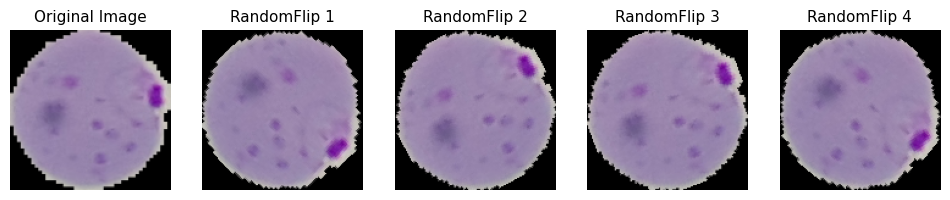

In [ ]:
layer = tf.keras.Sequential([
  layers.RandomRotation(factor=(-0.2, 0.2), fill_mode="constant", interpolation="nearest")
])
show_layer_effect(selected_image, layer)

3. **RandomZoom layer:** randomly zooms in or out on each axis of an image independently, filling empty space according to fill_mode.
        height_factor=0.2, width_factor=0.2, fill_mode="constant", interpolation="nearest"

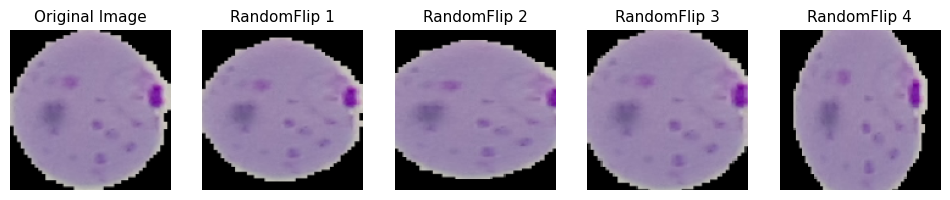

In [ ]:
layer = tf.keras.Sequential([
  layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="constant", interpolation="nearest")
])
show_layer_effect(selected_image, layer)

4. **RandomContrast layer:** randomly adjusts the contrast of an image by a random factor
          factor=0.2

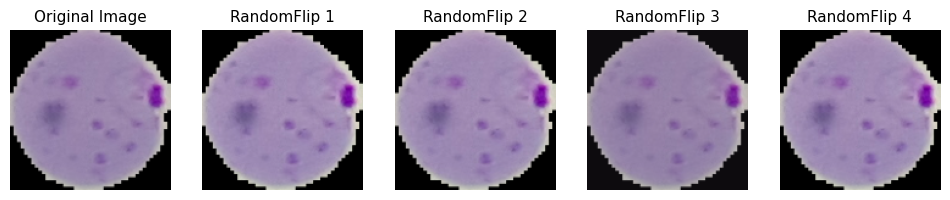

In [ ]:
layer = tf.keras.Sequential([
  layers.RandomContrast(factor=0.2)
])
show_layer_effect(selected_image, layer)

## **Model Architecture and Training**

To construct the model, we will first use the **Transfer Learning** technique, which involves taking a pretrained model that has been trained on a large dataset and using it as a base for the new model. This approach allows us to leverage the extensive feature extraction capabilities developed by the pretrained model. Then, the **Fine-Tuning** technique will be applied, where some of the upper layers of the same pretrained model will be unfrozen so they can be retrained during the training process. Fine-tuning will help in adapting the model more closely to our binary classification task.

The pretrained model that will be used is **NASNetMobile**, a neural network architecture that is part of the NASNet models family, developed by researchers at Google in 2018.

In addition to Transfer Learning and Fine-Tuning, **Dropout**, a regularization method to prevent overfitting, will also be used along with the **Data Augmentation** technique, as mentioned above.



In [ ]:
# Data aumentation with Keras Preprocessing layers
data_augmentation = keras.Sequential([
  layers.RandomFlip(mode="horizontal_and_vertical"),
  layers.RandomRotation(factor=(-0.2, 0.2), fill_mode="constant", interpolation="nearest"),
  layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="constant", interpolation="nearest"),
  layers.RandomContrast(factor=0.2)
])

Configuration of the EarlyStop callback from tf.Keras to monitor the 'loss' metric on the validation set and halt training if it does not improve for 5 consecutive epochs. The goal is to prevent overfitting and enhance training efficiency:

In [ ]:
earlyStop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

**Transfer Learning with NasNetMobile**

Downloading the base of the NASNetMobile model:

In [ ]:
base_model = keras.applications.NASNetMobile(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
print('NASNetMobile base structure: \n ')

base_model.summary()

19993432/19993432 [==============================] - 2s 0us/step
NASNetMobile base structure: 
 
Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 132, 132, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 65, 65, 32)           864       ['input_1[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 65, 65, 32)           128       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                               

Freezing layers to prevent them from being updated during training:

In [ ]:
base_model.trainable = False

In [ ]:
model = tf.keras.models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-5), metrics=[tf.keras.metrics.BinaryAccuracy()])

**Model training:**

In [ ]:
history = model.fit(optimized_train_data, epochs=100, validation_data=optimized_val_data, verbose = 2, callbacks=[earlyStop])

Epoch 1/100
547/547 - 78s - loss: 0.7104 - binary_accuracy: 0.5421 - val_loss: 0.6692 - val_binary_accuracy: 0.6027 - 78s/epoch - 143ms/step
Epoch 2/100
547/547 - 23s - loss: 0.6445 - binary_accuracy: 0.6254 - val_loss: 0.6164 - val_binary_accuracy: 0.6758 - 23s/epoch - 42ms/step
Epoch 3/100
547/547 - 24s - loss: 0.5981 - binary_accuracy: 0.6792 - val_loss: 0.5779 - val_binary_accuracy: 0.7158 - 24s/epoch - 44ms/step
Epoch 4/100
547/547 - 24s - loss: 0.5598 - binary_accuracy: 0.7212 - val_loss: 0.5443 - val_binary_accuracy: 0.7476 - 24s/epoch - 43ms/step
Epoch 5/100
547/547 - 24s - loss: 0.5248 - binary_accuracy: 0.7500 - val_loss: 0.5182 - val_binary_accuracy: 0.7665 - 24s/epoch - 43ms/step
Epoch 6/100
547/547 - 24s - loss: 0.5017 - binary_accuracy: 0.7691 - val_loss: 0.4982 - val_binary_accuracy: 0.7772 - 24s/epoch - 43ms/step
Epoch 7/100
547/547 - 24s - loss: 0.4793 - binary_accuracy: 0.7875 - val_loss: 0.4778 - val_binary_accuracy: 0.7946 - 24s/epoch - 43ms/step
Epoch 8/100
547/547

Visualization of the evolution of metrics during the training process:

In [ ]:
def plot_history(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = history.epoch

    plt.figure(figsize=(12, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

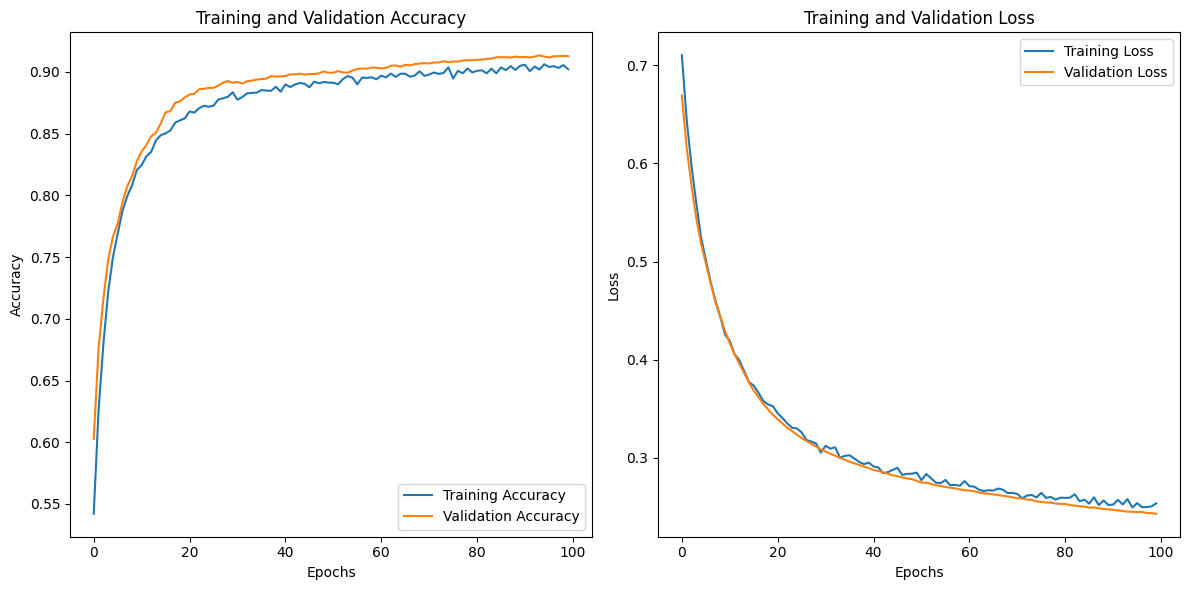

In [ ]:
plot_history(history)

**Applying Fine-Tuning:**

In [ ]:
def unfreeze_layers():
  trainable_layers = []
  for layer in base_model.layers:
    if "_12" in layer.name and "activation" not in layer.name:
      trainable_layers.append(layer.name)

  base_model.trainable = True
  set_trainable = False
  for layer in base_model.layers:
    if layer.name in trainable_layers:
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False

unfreeze_layers()

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-6), metrics=[tf.keras.metrics.BinaryAccuracy()])

Retraining the model with fine-tuning:

In [ ]:
history = model.fit(optimized_train_data, epochs=100, validation_data=optimized_val_data, verbose = 2, callbacks=[earlyStop])

Epoch 1/100
547/547 - 51s - loss: 0.4258 - binary_accuracy: 0.8525 - val_loss: 0.2391 - val_binary_accuracy: 0.9146 - 51s/epoch - 94ms/step
Epoch 2/100
547/547 - 27s - loss: 0.3440 - binary_accuracy: 0.8827 - val_loss: 0.2377 - val_binary_accuracy: 0.9173 - 27s/epoch - 49ms/step
Epoch 3/100
547/547 - 26s - loss: 0.3029 - binary_accuracy: 0.8973 - val_loss: 0.2342 - val_binary_accuracy: 0.9202 - 26s/epoch - 48ms/step
Epoch 4/100
547/547 - 27s - loss: 0.2836 - binary_accuracy: 0.9023 - val_loss: 0.2296 - val_binary_accuracy: 0.9232 - 27s/epoch - 49ms/step
Epoch 5/100
547/547 - 27s - loss: 0.2775 - binary_accuracy: 0.9029 - val_loss: 0.2244 - val_binary_accuracy: 0.9234 - 27s/epoch - 49ms/step
Epoch 6/100
547/547 - 27s - loss: 0.2670 - binary_accuracy: 0.9076 - val_loss: 0.2190 - val_binary_accuracy: 0.9240 - 27s/epoch - 49ms/step
Epoch 7/100
547/547 - 27s - loss: 0.2540 - binary_accuracy: 0.9102 - val_loss: 0.2141 - val_binary_accuracy: 0.9232 - 27s/epoch - 49ms/step
Epoch 8/100
547/547 

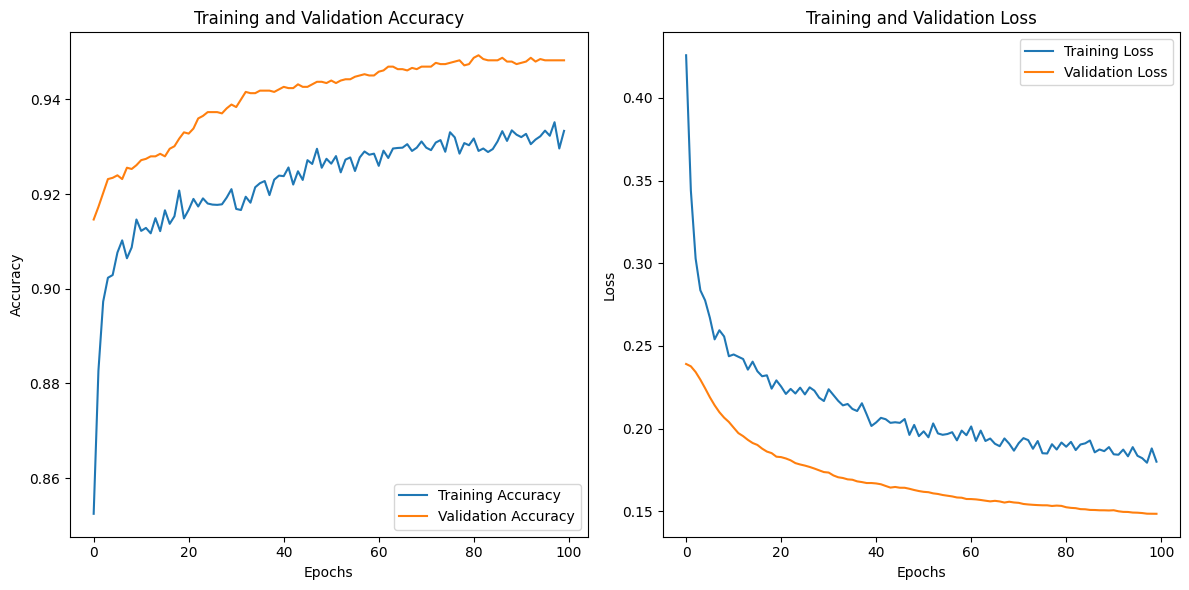

In [ ]:
plot_history(history)

In the graph showing the evolution of 'accuracy' and 'loss' metrics, better values are observed for the validation set than for the training set. This could be due to the use of the Dropout layer. This layer randomly 'drops out' a fraction of 20% of neurons in each epoch of training to prevent overfitting. However, during the evaluation of the validation set in model.fit(), the Dropout layer is not applied, and all neurons become active. This may result in better performance on the validation set compared to the training set, where Dropout has an effect.

Throughout this stage, explorations of transfer learning and fine-tuning have been carried out with different pretrained models such as VGG16, Xception, and EfficientNetB1. Although the VGG16 model achieved the best performance (about 96% accuracy on the test set), the decision was made to use NASNetMobile due to its good performance, small size (approximately 16.3 MB), and fast average inference time on CPU (just 27 ms compared to 70 ms for VGG16). These features represent a significant advantage as they make it feasible to deploy this model in production for various users.

Additionally, explorations have been conducted adjusting various hyperparameters such as the number of units per neuron, the number and structure of layers, and the learning rate value in the optimizer, among others. After analyzing and comparing the different results, it was concluded that this is the best model achieved so far.

## **Model saving**

The trained model is saved for future predictions and evaluations. To deploy the model in our Streamlit app, we perform a prior conversion to Tensorflow Lite format, allowing us to reduce its size while maintaining performance:

In [ ]:
model.save('malaria_model_TL.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("malaria_model_classification.tflite", "wb") as f:
    f.write(tflite_model)

## **Evaluation and predictions**

Now, let's evaluate with different metrics how the model works with new data never seen before:

In [ ]:
# Preparing test data for evaluation
test_data = test_data.map(preprocess_image)
test_data = configure_for_performance(test_data, test_size)

In [ ]:
# Evaluating the model on the test set
model.evaluate(test_data)

117/117 [==============================] - 33s 162ms/step - loss: 0.1398 - binary_accuracy: 0.9509


[0.13979454338550568, 0.9508547186851501]

On the test set, the model achieved a **loss of 13%** and an **accuracy of about 95%**.

Since this is a binary classification problem and the last layer of the model uses a sigmoid activation function, which outputs a value between 0 and 1, it is necessary to establish a threshold to determine whether this output value belongs to class 0, 'parasitized,' or class 1, 'uninfected.'

Because this model predicts whether a cell is infected with malaria or not, false negative errors could have serious consequences for the patient's health. Therefore, it would be ideal to establish a threshold based on the recommendations of healthcare professionals. However, for the exploratory purposes of this project, the default threshold of 0.5 will be maintained for calculating metrics and making predictions.

**Confusion Matrix:**

In [ ]:
def get_real_labels_and_predictions(dataset):
    real_labels = []
    predictions = []

    for batch in dataset:
        batch_images, batch_labels = batch
        batch_predictions = model.predict(batch_images, verbose=0)

        real_labels.extend(batch_labels.numpy())
        predictions.extend(batch_predictions)

    real_labels_tensor = tf.convert_to_tensor(real_labels)
    predictions_tensor = tf.convert_to_tensor([1 if p > 0.5 else 0 for p in predictions])

    return real_labels_tensor, predictions_tensor

real_labels, predictions = get_real_labels_and_predictions(test_data)


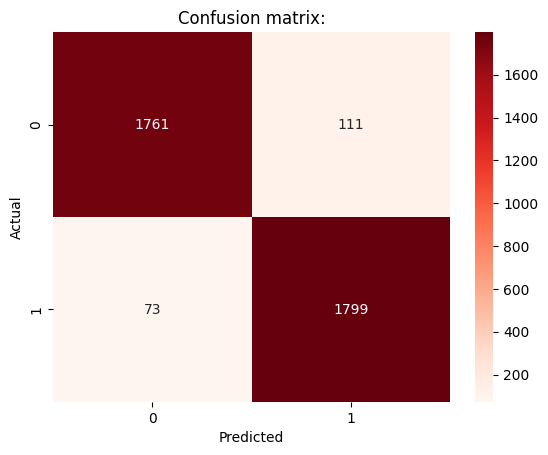

In [ ]:
def plot_confusion_matrix(actual, predicted):
  cm = tf.math.confusion_matrix(actual, predicted, num_classes=2)
  ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Reds')
  sns.set(rc={'figure.figsize':(5, 5)})
  ax.set_title('Confusion matrix:')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

plot_confusion_matrix(real_labels, predictions)

**Classification report:**

In [ ]:
print(classification_report(real_labels, predictions))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1872
           1       0.94      0.96      0.95      1872

    accuracy                           0.95      3744
   macro avg       0.95      0.95      0.95      3744
weighted avg       0.95      0.95      0.95      3744



**Making some predictions:**

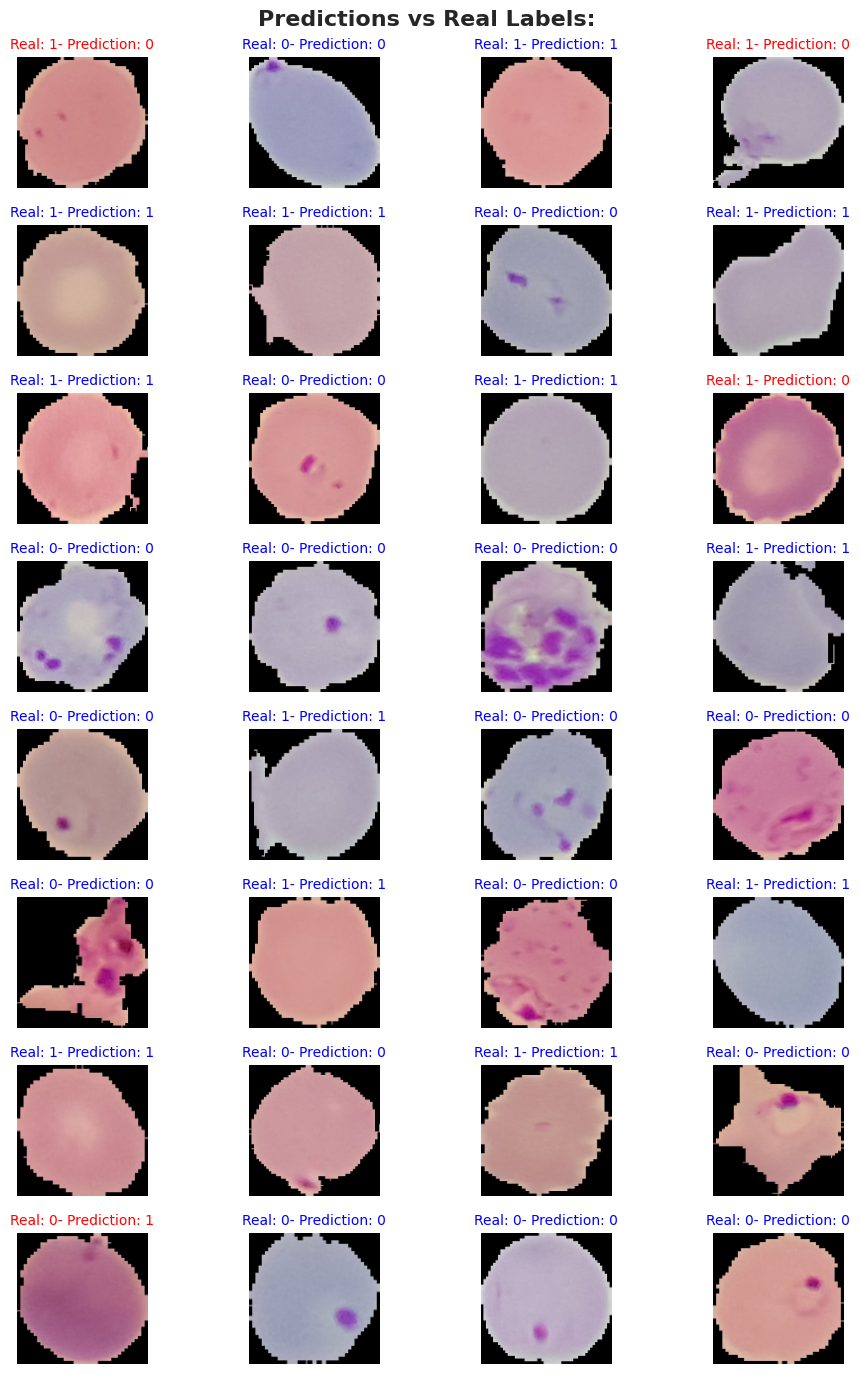

In [ ]:
def visualize_predictions(images, labels, predictions):
  fig, axes = plt.subplots(8, 4, figsize=(10, 14))
  fig.suptitle('Predictions vs Real Labels: ', fontsize=16, fontweight="bold")
  axes = axes.flatten()
  for i, ax in enumerate(axes):
      pred = 1 if predictions[i] > 0.5 else 0
      real = labels[i].numpy()
      if pred == real:
        color = "blue"
      else:
        color = "red"
      ax.imshow(images[i])
      ax.axis('off')
      ax.set_title(f"Real: {real}- Prediction: {pred}", fontsize=10, color=color)
  plt.tight_layout()
  plt.show()


for images, labels in test_data.take(1):
    pred = model.predict(images, verbose=0)
    visualize_predictions(images, labels, pred)

## **Conclusions**

Throughout this work, the aim was to go through all the stages involved in a machine learning project, from data acquisition and preparation to model deployment for usage. Various techniques and tools were explored in each of these stages with the goal of achieving the best possible results.

During evaluation, the model achieved approximately 95% accuracy. While we consider this a very good result, this project will remain open to future improvements with the aim of achieving an even more reliable model.

Before finishing:

The following code will download 10 images from each category (20 in total) from the test set. These images will be used to make predictions in the Streamlit application where the model will be deployed.

In [ ]:
output_directory = '/content/downloaded_images_1'
os.makedirs(output_directory, exist_ok=True)

In [ ]:
def download_images_by_class(dataset, output_folder, class_label, num_images):
    unbatched_dataset = dataset.unbatch()
    count = 0
    for image, label in unbatched_dataset:
      if tf.math.equal(label.numpy(), class_label):
          image_np = image.numpy()
          image_filename = f'{output_folder}/class__{class_label}_{count}.png'
          tf.keras.preprocessing.image.save_img(image_filename, image_np)
          count += 1
          if count >= num_images:
              break


In [ ]:
# Download 10 images from class 0 of the test set
download_images_by_class(test_data, output_directory, class_label=0, num_images=10)

# Download 10 images from class 1 of the test set
download_images_by_class(test_data, output_directory, class_label=1, num_images=10)

In [ ]:
# Create a zip file with the downloaded images
!zip -r /content/downloaded_images_1.zip /content/downloaded_images_1

  adding: content/downloaded_images_1/ (stored 0%)
  adding: content/downloaded_images_1/class__1_1.png (stored 0%)
  adding: content/downloaded_images_1/class__1_3.png (stored 0%)
  adding: content/downloaded_images_1/class__0_3.png (stored 0%)
  adding: content/downloaded_images_1/class__1_6.png (stored 0%)
  adding: content/downloaded_images_1/class__0_6.png (stored 0%)
  adding: content/downloaded_images_1/class__0_9.png (stored 0%)
  adding: content/downloaded_images_1/class__1_4.png (stored 0%)
  adding: content/downloaded_images_1/class__0_1.png (stored 0%)
  adding: content/downloaded_images_1/class__0_5.png (stored 0%)
  adding: content/downloaded_images_1/class__1_2.png (stored 0%)
  adding: content/downloaded_images_1/class__0_0.png (stored 0%)
  adding: content/downloaded_images_1/class__0_2.png (stored 0%)
  adding: content/downloaded_images_1/class__1_7.png (stored 0%)
  adding: content/downloaded_images_1/class__1_5.png (stored 0%)
  adding: content/downloaded_images_1/c

## **Bibliography and articles:**


* Chollet, F. (2017). Deep Learning with Python. Manning Publications Co.
* Moroney, L. (2021). AI and Machine Learning for Coders. O’Reilly Media, Inc.  
* Géron, A (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow. Second Edition. O’Reilly Media, Inc.
* [Stanford CS231n: Deep Learning for Computer Vision](https://cs231n.stanford.edu/)
* [Malaria Dataset](https://www.tensorflow.org/datasets/catalog/malaria)
*   [Load Data](https://www.tensorflow.org/tutorials/load_data/images)
*   [Data Augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)
*   [Overfit and Underfit](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)
*   [Working with processing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers)
*   [Image Classification from scratch](https://keras.io/examples/vision/image_classification_from_scratch/)
*   [Transfer Learning and fine-tuning guide](https://keras.io/guides/transfer_learning/)




## Licence

Restricted License
Copyright (c) 2024 Marina Comotti, Catriel Ramirez.

Under no circumstances is anyone who obtains a copy of this software and associated
documentation files (the "Software") allowed to deal with the Software in any way,
including, but not limited to, the rights to use, copy, modify, merge, publish,
distribute, sublicense, and/or sell copies of the Software. Additionally, individuals
to whom the Software is furnished are prohibited from making any use of it.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. UNDER NO EVENT SHALL
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
DEALINGS IN THE SOFTWARE.